In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)


module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_feature_values(feature_values):
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

In [9]:
#### filtering out procedure

#fluid_cohort = pd.read_pickle("data/low_bp_survival.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_team_activated.pkl")
fluid_cohort = pd.read_pickle("data/trauma_responder.pkl")

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]

x_train = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "treated",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            ])]

### normalize x_train 
#x = x_train.values 

min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_train_scaled)
x_train_scaled = imp.transform(x_train_scaled)

n, feature_size = x_train.shape
names = x_train.columns
device = "cuda:0"
rng = np.random.default_rng(0)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

x_train, x_test = x_train_scaled[train_inds], x_train_scaled[test_inds]
w_train, w_test = fluid_cohort["treated"].values[train_inds], fluid_cohort["treated"].values[test_inds]
y_train, y_test = fluid_cohort["outcome"].values[train_inds], fluid_cohort["outcome"].values[test_inds]


#### Getting top 10 features from multiple runs. 

seeds = np.arange(0, 6, 0.5, dtype=int)
results_sign = np.zeros((len(seeds), feature_size))

model = pseudo_outcome_nets.DRLearnerMask(  
                     x_train.shape[1],
                     binary_y=(len(np.unique(y_train)) == 2),
                     device="cuda:1",
                     n_layers_out=2,
                     n_units_out=100,
                     n_iter=1500,
                     batch_size=256,
                     batch_norm=False,
                     lr=1e-3,
                     patience=10,
                     nonlin="relu",
                     mask_dis = "Uniform"
                     )

model.fit(x_train, y_train, w_train)
feature_values = np.zeros((x_test.shape))

for test_ind in range(len(x_test)):

    instance = torch.from_numpy(x_test[test_ind, :])[None,:].to(device)
    game  = games.CateGame(instance, model)
    explanation = shapley_sampling.ShapleySampling(game, batch_size=128)
    feature_values[test_ind] = explanation.values.reshape(-1, x_test.shape[1])

### TODO: calcualte CIs across different seeds

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.5046299695968628, train_loss: 0.584998607635498
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.04387662932276726, train_loss: 0.16664712131023407
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.038696859031915665, train_loss: 0.1340145766735077
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.034523170441389084, train_loss: 0.13380125164985657
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.030147217214107513, train_loss: 0.10299832373857498
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.02637326344847679, train_loss: 0.10549597442150116
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.022430140525102615, train_loss: 0.09601575881242752
[po_estimator_0_impute_pos] Epoch: 350, current validation loss: 0.01871008425951004, train_loss: 0.08772803843021393
[po_estimator_0_impute_pos] Epoch: 400, current validation 

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


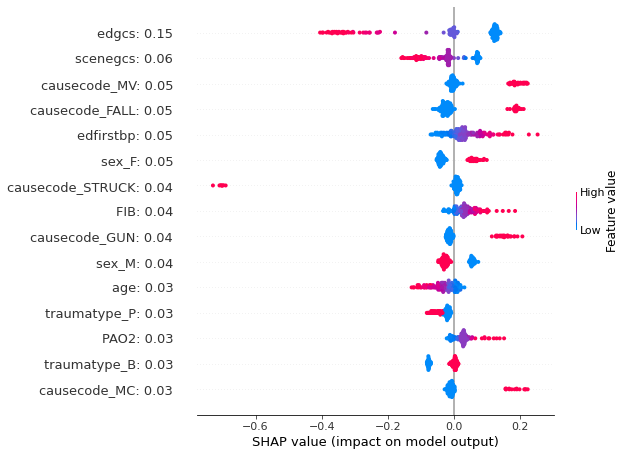

In [10]:

ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]

feature_names = [
    a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
]

shap.summary_plot(
    feature_values[:, ind],
    x_test[:, ind], 
    feature_names=feature_names,
    title = "missingness during training"
 )

In [12]:
y_pred = model(x_test)

TypeError: predict() missing 1 required positional argument: 'M'